In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
from scipy import stats
import statsmodels.api as sm

In [2]:
fileroot='../../Data/'
figureroot=fileroot+'Figures/'

In [3]:
cd4=pd.read_pickle(fileroot+'CD4_sequences.pkl')
cd8=pd.read_pickle(fileroot+'CD8_sequences.pkl')

In [4]:
aa='GALSTNKVYRIQDFPEMWHC'
def get_aa_counts(cdr3):
    return np.array([cdr3[1:-1].count(x) for x in aa])/len(cdr3)

In [5]:
for i in cd4.Subject.unique():
    a4=pd.DataFrame(list(map(get_aa_counts,cd4[cd4.Subject==i].CDR3a)),columns=[x for x in aa]).melt()
    a8=pd.DataFrame(list(map(get_aa_counts,cd8[cd8.Subject==i].CDR3a)),columns=[x for x in aa]).melt()
    b4=pd.DataFrame(list(map(get_aa_counts,cd4[cd4.Subject==i].CDR3b)),columns=[x for x in aa]).melt()
    b8=pd.DataFrame(list(map(get_aa_counts,cd8[cd8.Subject==i].CDR3b)),columns=[x for x in aa]).melt()
    a4['Hue']=['Four']*a4.shape[0]
    a8['Hue']=['Eight']*a8.shape[0]
    b4['Hue']=['Four']*b4.shape[0]
    b8['Hue']=['Eight']*b8.shape[0]
    alpha=a4.append(a8)
    beta=b4.append(b8)
    alpha['Subject']=[i]*alpha.shape[0]
    beta['Subject']=[i]*beta.shape[0]
    if i==0:
        df_alpha=alpha
        df_beta=beta
    else:
        df_alpha=df_alpha.append(alpha)
        df_beta=df_beta.append(beta)

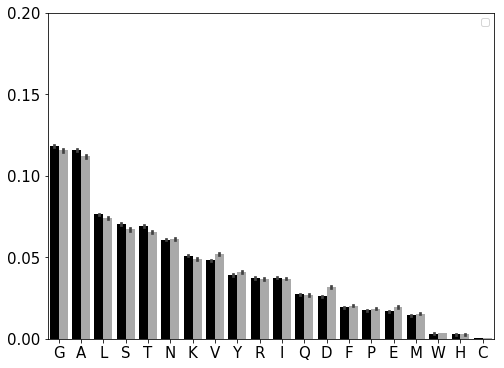

In [6]:
a4_dims = (8,6)
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(x='variable',y='value',hue='Hue',data=df_alpha,palette=['Black','DarkGray'])
plt.ylim([0,.2])
plt.xlabel('')
plt.ylabel('')
plt.yticks(np.arange(0,.25,.05),fontsize=15)
plt.xticks(fontsize=15)
plt.legend('')
plt.show()
plt.close()

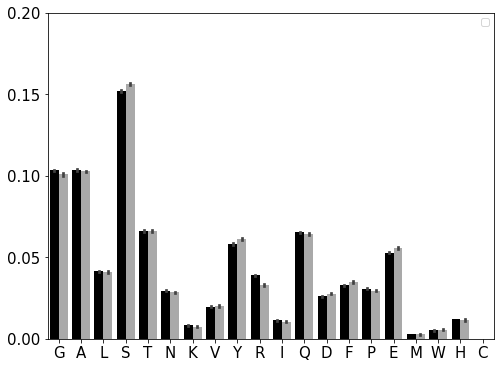

In [7]:
a4_dims = (8,6)
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(x='variable',y='value',hue='Hue',data=df_beta,palette=['Black','DarkGray'])
plt.ylim([0,.2])
plt.xlabel('')
plt.ylabel('')
plt.yticks(np.arange(0,.25,.05),fontsize=15)
plt.xticks(fontsize=15)
plt.legend('')
plt.show()
plt.close()

In [8]:
def individual_create(df_alpha):
    for i in cd4.Subject.unique():
        a=df_alpha[df_alpha.Subject==i]
        means=[]
        for acid in aa:
            four_freq=np.mean(a[(a.Hue=='Four') & (a.variable==acid)].value)
            eight_freq=np.mean(a[(a.Hue=='Eight') & (a.variable==acid)].value)
            if eight_freq>0:
                means.append(four_freq/eight_freq)
            else:
                means.append(1)
        if i==0:
            df=np.array(means)
        else:
            df=np.vstack((df,np.array(means)))
    data=pd.DataFrame(df,columns=[x for x in aa]).melt()
    data.value=np.log10(data.value.astype(float))
    return data

In [9]:
def individual_plot(data,figure):
    sns.swarmplot(x='variable',y='value',data=data,palette=['darkgray'],zorder=1)
    sns.pointplot(x='variable',y='value',data=data,linestyles=[""],color='k',zorder=2,ci='sd',errwidth=1.5, scale=.75)
    plt.plot([-1,21],[0,0],'--k')
    plt.ylim([-.3,.3])
    plt.ylabel('')
    plt.xlabel('')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.tight_layout()
    plt.show()
    plt.close()

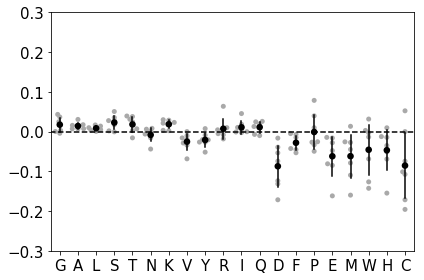

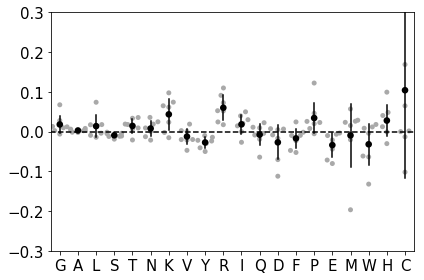

In [10]:
for x,figure in zip([df_alpha,df_beta],['Figure3_C','Figure3_D']):
    data=individual_create(x)
    individual_plot(data,figure)

In [11]:
def get_cdr3_charge(cdr3):
    return cdr3.count('K')+cdr3.count('R')-cdr3.count('D')-cdr3.count('E')

In [12]:
for i in cd4.Subject.unique():
    a4=pd.DataFrame(list(map(get_cdr3_charge,cd4[cd4.Subject==i].CDR3a)),columns=['Charge']).melt()
    a8=pd.DataFrame(list(map(get_cdr3_charge,cd8[cd8.Subject==i].CDR3a)),columns=['Charge']).melt()
    b4=pd.DataFrame(list(map(get_cdr3_charge,cd4[cd4.Subject==i].CDR3b)),columns=['Charge']).melt()
    b8=pd.DataFrame(list(map(get_cdr3_charge,cd8[cd8.Subject==i].CDR3b)),columns=['Charge']).melt()
    a4['Hue']=['Four']*a4.shape[0]
    a8['Hue']=['Eight']*a8.shape[0]
    b4['Hue']=['Four']*b4.shape[0]
    b8['Hue']=['Eight']*b8.shape[0]
    alpha=a4.append(a8)
    beta=b4.append(b8)
    alpha['Subject']=[i]*alpha.shape[0]
    beta['Subject']=[i]*beta.shape[0]
    if i==0:
        df_alpha=alpha
        df_beta=beta
    else:
        df_alpha=df_alpha.append(alpha)
        df_beta=df_beta.append(beta)

In [13]:
def odds_ratio(df,chain):
    odds=np.zeros(len(df.value.unique()))
    pvalue=np.zeros(len(df.value.unique()))
    lower_ci=np.zeros(len(df.value.unique()))
    upper_ci=np.zeros(len(df.value.unique()))
    features=[]
    for i,x in enumerate(df.value.unique()):
        a=df[(df.Hue=='Four') & (df.value==x)].shape[0]
        b=df[(df.Hue=='Eight') & (df.value==x)].shape[0]
        c=df[df.Hue=='Four'].shape[0]-a
        d=df[df.Hue=='Eight'].shape[0]-b
        odds[i],pvalue[i]=stats.fisher_exact([[a,b],[c,d]])  
        lower_ci[i],upper_ci[i]=sm.stats.Table2x2(np.asarray([[a,b],[c,d]])).oddsratio_confint(alpha=0.05, method='normal')
        features.append(x)
    order=np.argsort(features)
    pvalue=pvalue*len(features)
    features,odds,pvalue,lower_ci,upper_ci=np.array(features)[order],odds[order],pvalue[order],lower_ci[order],upper_ci[order]
    return pd.DataFrame(np.vstack((odds,pvalue,lower_ci,upper_ci,[chain]*len(odds))).T,index=features,columns=['OR','pvalue','lower_ci','upper_ci','Chain'])

In [14]:
alpha=odds_ratio(df_alpha,'Alpha')
beta=odds_ratio(df_beta,'Beta')
df=alpha.append(beta)
df[['OR','pvalue','lower_ci','upper_ci']]=df[['OR','pvalue','lower_ci','upper_ci']].astype(float)
df=df[df.pvalue<.2]

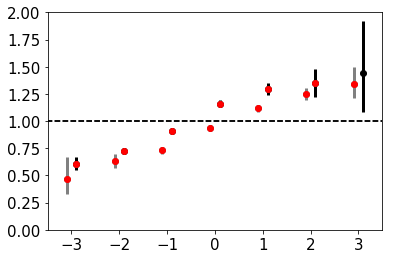

In [15]:
for chain,change,color in zip(['Alpha','Beta'],[-.1,.1],['Gray','Black']):
    data=df[df.Chain==chain]
    plt.errorbar(data.index+change,data.OR,[data.OR-data.lower_ci,data.upper_ci-data.OR],fmt='o',markersize=1,ecolor=color,color=color,lw=3,zorder=1)
    plt.scatter(data.index+change,data.OR,color=color)
    plt.scatter(data[data.pvalue<.05].index+change,data[data.pvalue<.05].OR,color='r',zorder=2)
    plt.plot([-10,10],[1,1],'--k')
    plt.xlim([-3.5,3.5])
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylim([0,2])
plt.show()
plt.close()

In [16]:
def paired_chain_OR(cd4,cd8,feature1,feature2):
    features1=np.unique(np.hstack((np.unique(cd4[feature1]),np.unique(cd8[feature1]))))
    features2=np.unique(np.hstack((np.unique(cd4[feature2]),np.unique(cd8[feature2]))))

    fours=pd.DataFrame(np.zeros((len(features1),len(features2))),columns=features2,index=features1)
    eights=pd.DataFrame(np.zeros((len(features1),len(features2))),columns=features2,index=features1)

    for f1,f2 in zip(cd4[feature1],cd4[feature2]):
        fours[f2].loc[f1]+=1
    for f1,f2 in zip(cd8[feature1],cd8[feature2]):
        eights[f2].loc[f1]+=1

    odds=pd.DataFrame(np.zeros((len(features1),len(features2))),columns=features2,index=features1)
    pvalue=pd.DataFrame(np.zeros((len(features1),len(features2))),columns=features2,index=features1)
    for f1 in features1:
        for f2 in features2:
            a=fours[f2].loc[f1]
            b=eights[f2].loc[f1]
            c=fours.sum().sum()-a
            d=eights.sum().sum()-b
            if a+b>0:
                odds[f2].loc[f1],pvalue[f2].loc[f1]=stats.fisher_exact([[a,b],[c,d]])  
    pvalue=pd.DataFrame(np.array(pvalue)*odds.shape[0]*odds.shape[1],columns=odds.columns,index=odds.index)
    pvalue[(pvalue>.05) | (pvalue==0)]=0
    odds[pvalue==0]=0
    odds=odds[odds.columns[np.sum(odds,axis=0)!=0]]
    odds=odds[np.sum(odds,axis=1)!=0]
    pvalue=pvalue[odds.columns]
    pvalue=pvalue.loc[odds.index]
    odds[odds==0]=1
    odds[~np.isfinite(odds)]=1
    return odds

In [17]:
cd4['Alpha_charge']=list(map(get_cdr3_charge,cd4.CDR3a))
cd4['Beta_charge']=list(map(get_cdr3_charge,cd4.CDR3b))
cd8['Alpha_charge']=list(map(get_cdr3_charge,cd8.CDR3a))
cd8['Beta_charge']=list(map(get_cdr3_charge,cd8.CDR3b))                        

In [18]:
odds=paired_chain_OR(cd4,cd8,'Alpha_charge','Beta_charge')

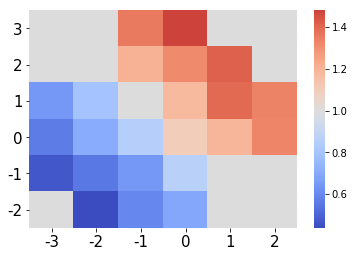

In [19]:
sns.heatmap(odds.loc[odds.index[::-1]],cmap='coolwarm',center=1)
plt.yticks(rotation=0,fontsize=15)
plt.xticks(fontsize=15)
plt.show()
plt.close()

In [20]:
paired=np.array(odds).flatten()
data=pd.DataFrame(np.vstack((paired,['Paired']*len(paired))).T)
data=data.append(pd.DataFrame(np.vstack((np.array(df[df.pvalue<.05].OR),['Single']*df[df.pvalue<.05].shape[0])).T))
data.columns=['OR','Hue']
data['x']=[0]*data.shape[0]
data=data[data.OR.astype(float)!=1.0]
data[['OR','x']]=data[['OR','x']].astype(float)

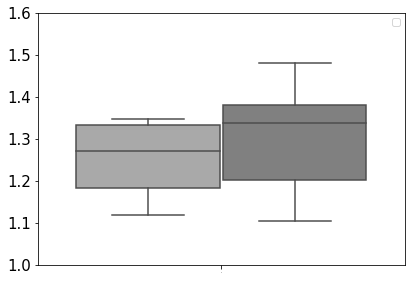

In [21]:
sns.boxplot(x='x',y='OR',hue='Hue',data=data[data.OR>1],hue_order=['Single','Paired'],palette=['Darkgray','Gray'])
plt.legend('')
plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize=0)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.ylim([1,1.6])
plt.show()
plt.close()

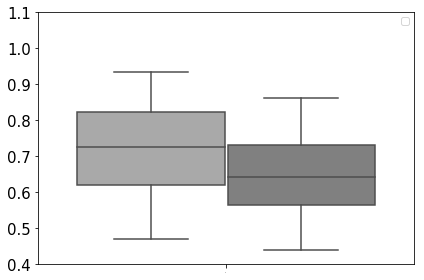

In [22]:
sns.boxplot(x='x',y='OR',hue='Hue',data=data[data.OR<1],hue_order=['Single','Paired'],palette=['Darkgray','Gray'])
plt.legend('')
plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize=0)
plt.yticks(fontsize=15)
plt.ylim([.4,1.1])
plt.tight_layout()
plt.show()
plt.close()

In [23]:
stats.mannwhitneyu(data[(data.OR>1) & (data.Hue=='Paired')].OR,data[(data.OR>1) & (data.Hue=='Single')].OR)

MannwhitneyuResult(statistic=24.0, pvalue=0.1964743394677168)

In [24]:
stats.mannwhitneyu(data[(data.OR<1) & (data.Hue=='Paired')].OR,data[(data.OR<1) & (data.Hue=='Single')].OR)

MannwhitneyuResult(statistic=30.0, pvalue=0.16554333549676253)

In [25]:
for i in cd4.Subject.unique():
    a4=pd.DataFrame(list(map(len,cd4[cd4.Subject==i].CDR3a)),columns=['Charge']).melt()
    a8=pd.DataFrame(list(map(len,cd8[cd8.Subject==i].CDR3a)),columns=['Charge']).melt()
    b4=pd.DataFrame(list(map(len,cd4[cd4.Subject==i].CDR3b)),columns=['Charge']).melt()
    b8=pd.DataFrame(list(map(len,cd8[cd8.Subject==i].CDR3b)),columns=['Charge']).melt()
    a4['Hue']=['Four']*a4.shape[0]
    a8['Hue']=['Eight']*a8.shape[0]
    b4['Hue']=['Four']*b4.shape[0]
    b8['Hue']=['Eight']*b8.shape[0]
    alpha=a4.append(a8)
    beta=b4.append(b8)
    alpha['Subject']=[i]*alpha.shape[0]
    beta['Subject']=[i]*beta.shape[0]
    if i==0:
        df_alpha=alpha
        df_beta=beta
    else:
        df_alpha=df_alpha.append(alpha)
        df_beta=df_beta.append(beta)

In [26]:
alpha=odds_ratio(df_alpha,'Alpha')
beta=odds_ratio(df_beta,'Beta')
df=alpha.append(beta)
df[['OR','pvalue','lower_ci','upper_ci']]=df[['OR','pvalue','lower_ci','upper_ci']].astype(float)
df=df.loc[np.arange(9,21)]

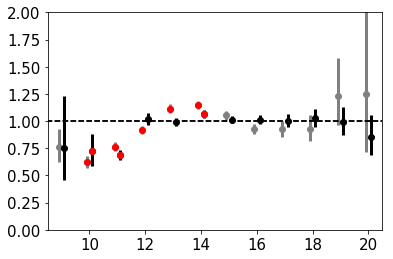

In [27]:
for chain,change,color in zip(['Alpha','Beta'],[-.1,.1],['Gray','Black']):
    data=df[df.Chain==chain]
    plt.errorbar(data.index+change,data.OR,[data.OR-data.lower_ci,data.upper_ci-data.OR],fmt='o',markersize=1,ecolor=color,color=color,lw=3,zorder=1)
    plt.scatter(data.index+change,data.OR,color=color)
    plt.scatter(data[data.pvalue<.05].index+change,data[data.pvalue<.05].OR,color='r',zorder=2)
    plt.plot([0,30],[1,1],'--k')
    plt.xlim([8.5,20.5])
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylim([0,2])
plt.show()
plt.close()

In [28]:
cd4['Alpha_length']=list(map(len,cd4.CDR3a))
cd4['Beta_length']=list(map(len,cd4.CDR3b))
cd8['Alpha_length']=list(map(len,cd8.CDR3a))
cd8['Beta_length']=list(map(len,cd8.CDR3b))  

In [29]:
odds=paired_chain_OR(cd4,cd8,'Alpha_length','Beta_length')

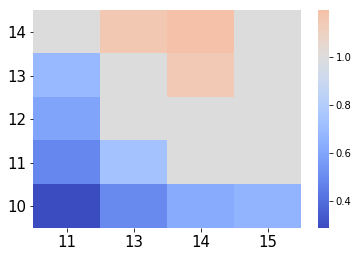

In [30]:
sns.heatmap(odds.loc[odds.index[::-1]],cmap='coolwarm',center=1)
plt.yticks(rotation=0,fontsize=15)
plt.xticks(fontsize=15)
plt.show()
plt.close()

In [31]:
paired=np.array(odds).flatten()
data=pd.DataFrame(np.vstack((paired,['Paired']*len(paired))).T)
data=data.append(pd.DataFrame(np.vstack((np.array(df[df.pvalue<.05].OR),['Single']*df[df.pvalue<.05].shape[0])).T))
data.columns=['OR','Hue']
data['x']=[0]*data.shape[0]
data=data[data.OR.astype(float)!=1.0]
data[['OR','x']]=data[['OR','x']].astype(float)

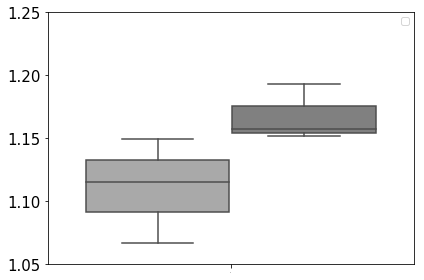

In [32]:
sns.boxplot(x='x',y='OR',hue='Hue',data=data[data.OR>1],hue_order=['Single','Paired'],palette=['Darkgray','Gray'])
plt.legend('')
plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize=0)
plt.yticks(np.arange(1,1.3,.05),fontsize=15)
plt.tight_layout()
plt.ylim([1.05,1.25])
plt.show()
plt.close()

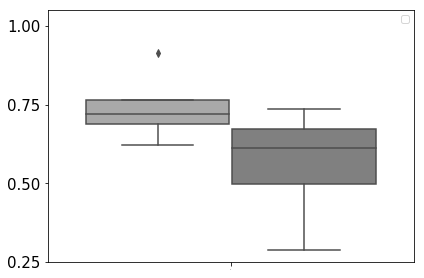

In [33]:
sns.boxplot(x='x',y='OR',hue='Hue',data=data[data.OR<1],hue_order=['Single','Paired'],palette=['Darkgray','Gray'])
plt.legend('')
plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize=0)
plt.yticks(np.arange(.25,1.25,.25),fontsize=15)
plt.tight_layout()
plt.ylim([.25,1.05])
plt.show()
plt.close()

In [34]:
stats.mannwhitneyu(data[(data.OR>1) & (data.Hue=='Paired')].OR,data[(data.OR>1) & (data.Hue=='Single')].OR)

MannwhitneyuResult(statistic=0.0, pvalue=0.04042779918502612)

In [35]:
stats.mannwhitneyu(data[(data.OR<1) & (data.Hue=='Paired')].OR,data[(data.OR<1) & (data.Hue=='Single')].OR)

MannwhitneyuResult(statistic=7.0, pvalue=0.03363898026917449)